# Exploration 7
## Portrait mode with blur and chroma key

1) 인물모드 사진을 성공적으로 제작 - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하기   
2) 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적 - 인물사진에서 발생한 문제점을 정확히 지적한 사진 제출하기   
3) 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시 - 추가적인 depth정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하기

## Step1. 인물모드 직접 해보기
### 아웃포커싱 효과 적용하기

(3024, 3024, 3)


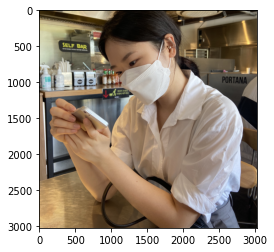

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

my_img_1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_1.png'  
my_img_1_orig = cv2.imread(my_img_1_path)

print(my_img_1_orig.shape)
plt.imshow(cv2.cvtColor(my_img_1_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff470a72880>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [4]:
segvalues, output = model.segmentAsPascalvoc(my_img_1_path)

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

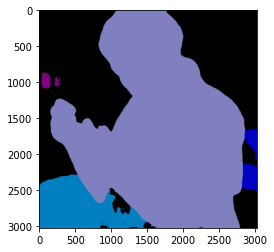

In [6]:
plt.imshow(output)
plt.show()

In [7]:
print(segvalues)

{'class_ids': array([ 0,  5,  9, 11, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}


In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
chair
diningtable
person


In [9]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
print(colormap[15]) # person

[192 128 128]


In [11]:
# 여기서 주의할 것은 output 이미지가 BGR순서로 채널 배치가 되어 있다는 점이에요.
# colormap은 RGB 순서이고요.
# 그래서 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 합니다.
seg_color = (128,128,192)

(3024, 3024)


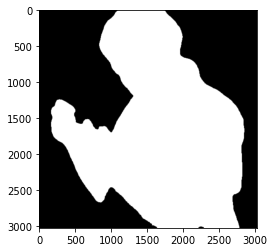

In [12]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

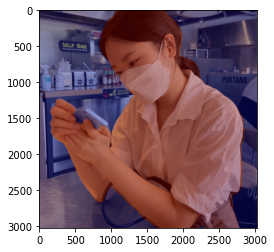

In [13]:
my_img_1_show = my_img_1_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다.
my_img_1_mask = seg_map.astype(np.uint8)*255

# 255와 0을 적당한 색상으로 바꿔봅니다.
color_mask = cv2.applyColorMap(my_img_1_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
my_img_1_show = cv2.addWeighted(my_img_1_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(my_img_1_show, cv2.COLOR_BGR2RGB))
plt.show()

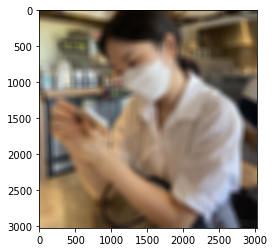

In [14]:
# (13,13)은 blurring kernel size를 뜻합니다.
# kernel은 행렬을 의미하는데 kernel의 크기가 크면 이미지 전체가 blur처리가 많이 됩니다.
# 다양하게 바꿔보세요
my_img_1_orig_blur = cv2.blur(my_img_1_orig, (100,100))
plt.imshow(cv2.cvtColor(my_img_1_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

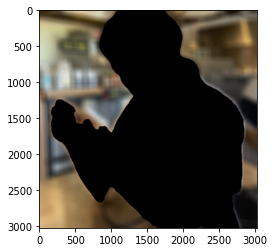

In [15]:
my_img_1_mask_color = cv2.cvtColor(my_img_1_mask, cv2.COLOR_GRAY2BGR)
my_img_1_bg_mask = cv2.bitwise_not(my_img_1_mask_color)
my_img_1_bg_blur = cv2.bitwise_and(my_img_1_orig_blur, my_img_1_bg_mask)
plt.imshow(cv2.cvtColor(my_img_1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

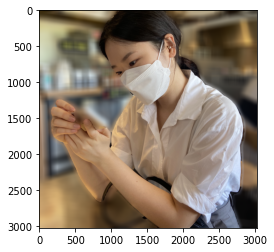

In [16]:
my_img_1_concat = np.where(my_img_1_mask_color==255, my_img_1_orig, my_img_1_bg_blur)
plt.imshow(cv2.cvtColor(my_img_1_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 크로마키 배경 합성

(3024, 3024, 3)


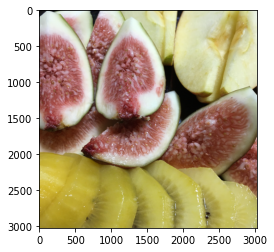

In [17]:
# 배경으로 사용할 이미지 불러오기
bg_img_1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg_img_1.png'  
bg_img_1_orig = cv2.imread(bg_img_1_path)

print(bg_img_1_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_1_orig, cv2.COLOR_BGR2RGB))
plt.show()

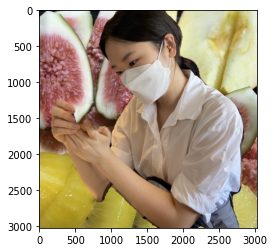

In [18]:
img_1 = cv2.copyTo(bg_img_1_orig, my_img_1_bg_mask, my_img_1_orig)
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 사진 - 아웃포커싱 효과 적용하기

(3024, 3024, 3)


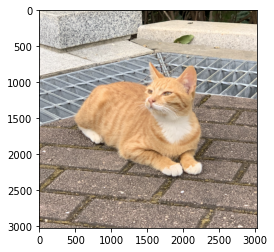

In [19]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
cat_orig = cv2.imread(cat_path)

print(cat_orig.shape)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
segvalues, output = model.segmentAsPascalvoc(cat_path)

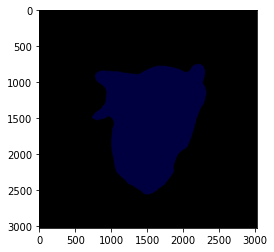

In [21]:
plt.imshow(output)
plt.show()

* 여기서 고양이가 계속 반시계방향으로 90도 회전되어서 출력된다.... 똑같은 방법을 적용한 다른 사진들은 제대로 출력되는데 이런 오류?가 발생하는 이유를 못 찾았다.
* 대신 시계방향으로 90도 회전시켜 원래 얻고자했던 이미지를 출력해주고 다음 과정들을 진행하였다.

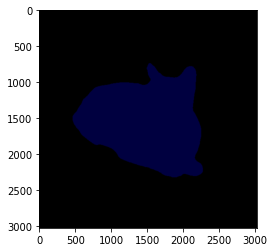

In [22]:
output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(output)
plt.show()

In [23]:
colormap[8] # cat

array([64,  0,  0])

In [24]:
seg_color = (0, 0, 64)

(3024, 3024)


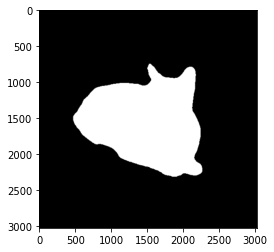

In [25]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

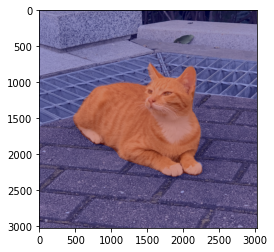

In [26]:
cat_show = cat_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다.
cat_mask = seg_map.astype(np.uint8)*255

# 255와 0을 적당한 색상으로 바꿔봅니다.
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

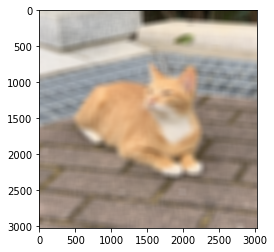

In [27]:
# (13,13)은 blurring kernel size를 뜻합니다.
# kernel은 행렬을 의미하는데 kernel의 크기가 크면 이미지 전체가 blur처리가 많이 됩니다.
# 다양하게 바꿔보세요
cat_orig_blur = cv2.blur(cat_orig, (100,100))
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

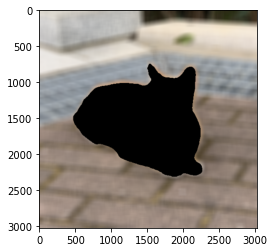

In [28]:
cat_mask_color = cv2.cvtColor(cat_mask, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

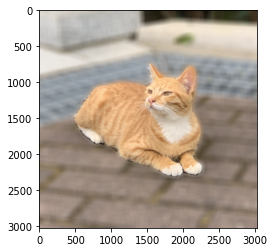

In [29]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 두 번째 사진 - 아웃포커싱 효과 적용하기

(3024, 3024, 3)


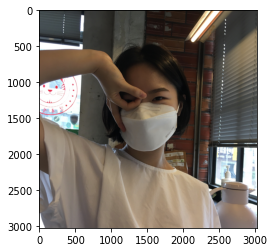

In [30]:
my_img_2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_2.png'  
my_img_2_orig = cv2.imread(my_img_2_path)

print(my_img_2_orig.shape)
plt.imshow(cv2.cvtColor(my_img_2_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
segvalues, output = model.segmentAsPascalvoc(my_img_2_path)

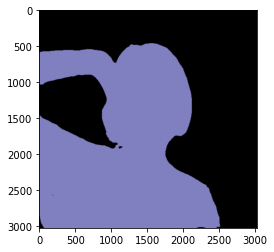

In [32]:
plt.imshow(output)
plt.show()

In [33]:
print(colormap[15]) # person

[192 128 128]


In [34]:
seg_color = (128,128,192)

(3024, 3024)


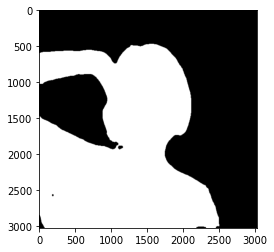

In [35]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

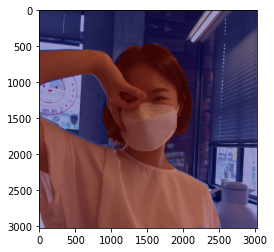

In [36]:
my_img_2_show = my_img_2_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다.
my_img_2_mask = seg_map.astype(np.uint8)*255

# 255와 0을 적당한 색상으로 바꿔봅니다.
color_mask = cv2.applyColorMap(my_img_2_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
my_img_2_show = cv2.addWeighted(my_img_2_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(my_img_2_show, cv2.COLOR_BGR2RGB))
plt.show()

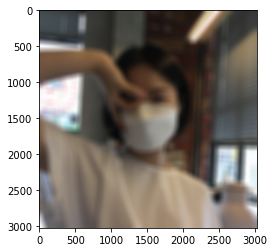

In [37]:
my_img_2_orig_blur = cv2.blur(my_img_2_orig, (100,100))
plt.imshow(cv2.cvtColor(my_img_2_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

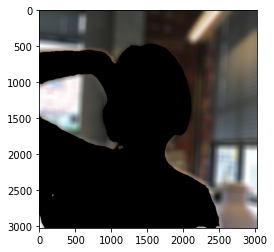

In [38]:
my_img_2_mask_color = cv2.cvtColor(my_img_2_mask, cv2.COLOR_GRAY2BGR)
my_img_2_bg_mask = cv2.bitwise_not(my_img_2_mask_color)
my_img_2_bg_blur = cv2.bitwise_and(my_img_2_orig_blur, my_img_2_bg_mask)
plt.imshow(cv2.cvtColor(my_img_2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

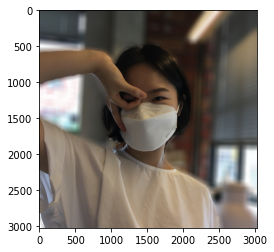

In [39]:
my_img_2_concat = np.where(my_img_2_mask_color==255, my_img_2_orig, my_img_2_bg_blur)
plt.imshow(cv2.cvtColor(my_img_2_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 두번째 사진 - 크로마키 배경 합성하기

(3024, 3024, 3)


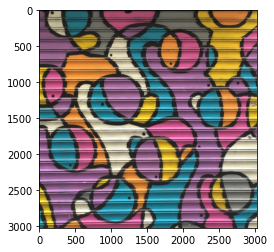

In [40]:
# 배경으로 사용할 이미지 불러오기
bg_img_2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg_img_2.png'  
bg_img_2_orig = cv2.imread(bg_img_2_path)

print(bg_img_2_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_2_orig, cv2.COLOR_BGR2RGB))
plt.show()

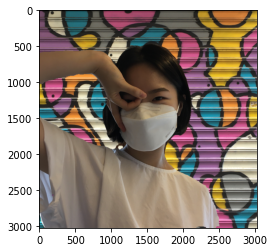

In [41]:
img_2 = cv2.copyTo(bg_img_2_orig, my_img_2_bg_mask, my_img_2_orig)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()

### 세번째 사진 - 아웃포커싱 효과 적용하기

(3024, 3024, 3)


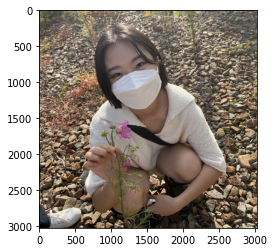

In [42]:
my_img_3_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_3.png'  
my_img_3_orig = cv2.imread(my_img_3_path)

print(my_img_3_orig.shape)
plt.imshow(cv2.cvtColor(my_img_3_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
segvalues, output = model.segmentAsPascalvoc(my_img_3_path)

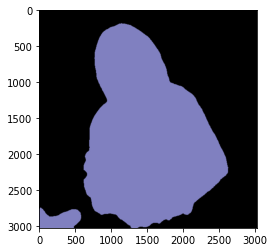

In [44]:
plt.imshow(output)
plt.show()

In [45]:
print(colormap[15]) # person

[192 128 128]


In [46]:
seg_color = (128,128,192)

(3024, 3024)


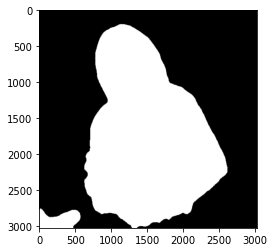

In [47]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

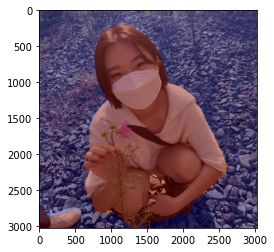

In [48]:
my_img_3_show = my_img_3_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다.
my_img_3_mask = seg_map.astype(np.uint8)*255

# 255와 0을 적당한 색상으로 바꿔봅니다.
color_mask = cv2.applyColorMap(my_img_3_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
my_img_3_show = cv2.addWeighted(my_img_3_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(my_img_3_show, cv2.COLOR_BGR2RGB))
plt.show()

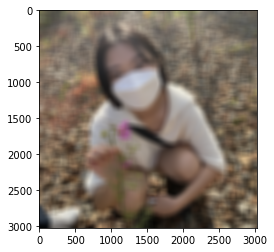

In [49]:
my_img_3_orig_blur = cv2.blur(my_img_3_orig, (100,100))
plt.imshow(cv2.cvtColor(my_img_3_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

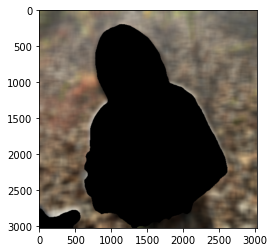

In [50]:
my_img_3_mask_color = cv2.cvtColor(my_img_3_mask, cv2.COLOR_GRAY2BGR)
my_img_3_bg_mask = cv2.bitwise_not(my_img_3_mask_color)
my_img_3_bg_blur = cv2.bitwise_and(my_img_3_orig_blur, my_img_3_bg_mask)
plt.imshow(cv2.cvtColor(my_img_3_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

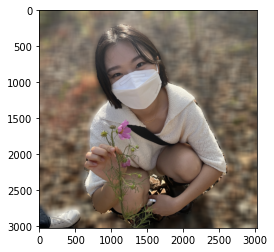

In [51]:
my_img_3_concat = np.where(my_img_3_mask_color==255, my_img_3_orig, my_img_3_bg_blur)
plt.imshow(cv2.cvtColor(my_img_3_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 세번째 사진 - 크로마키 배경 합성하기

(3024, 3024, 3)


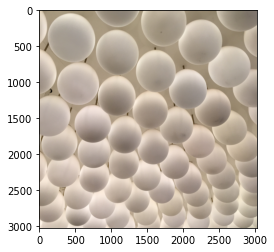

In [52]:
# 배경으로 사용할 이미지 불러오기
bg_img_3_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg_img_3.png'  
bg_img_3_orig = cv2.imread(bg_img_3_path)

print(bg_img_3_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_3_orig, cv2.COLOR_BGR2RGB))
plt.show()

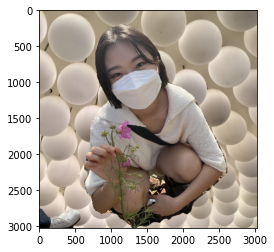

In [53]:
img_3 = cv2.copyTo(bg_img_3_orig, my_img_3_bg_mask, my_img_3_orig)
plt.imshow(cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB))
plt.show()

## Step2. 사진에서 문제점 찾기

사진챕쳐해서 문제점 표시한 뒤 다시 이미지 출력하기

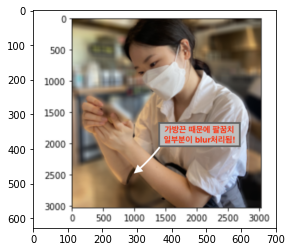

In [55]:
my_img_1_error_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_1_error.png'  
my_img_1_error = cv2.imread(my_img_1_error_path)

plt.imshow(cv2.cvtColor(my_img_1_error, cv2.COLOR_BGR2RGB))
plt.show()

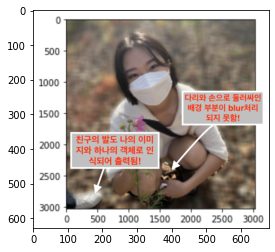

In [57]:
my_img_3_error_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_img_3_error.png'  
my_img_3_error = cv2.imread(my_img_3_error_path)

plt.imshow(cv2.cvtColor(my_img_3_error, cv2.COLOR_BGR2RGB))
plt.show()

## Step3. 해결 방법 제안해보기

### 🤔**cs231n lecture-11 참고**🤔  
Semantic Segmentation은 이미지의 픽셀들이 어떤 클래스에 속하는지 예측하는 과정이다. 하지만 개별 객체가 구분되지 않는 단점이 있다. 이 단점을 보완하기 위해 **Instance Segmentation** 방법을 사용할 수 있다.   
       
Instance Segmentation은 각각의 픽셀별로 카테고리 score를 매기는 방식이 아니라, 각 픽셀별로 Object가 있는지 없는지 여부만 계산한다.    
       
일반적으로 Mask R-CNN과 같은 2-stage detector에서는 먼저 object들을 bounding box를 통해 localization시킨다. 그 후 localize된 RoI(Regions of Interest, 관심영역)마다 class의 개수만큼 binary mask(instance인지 아닌지)를 씌워준다. Semantic Segmentation과 다르게 이미지 사이즈 크기로 class 개수만큼 output 채널이 존재하지 않고 **RoI별로 class 개수만큼 output 채널이 존재**하고 동일 class더라도 서로다른 instance, 즉 **RoI가 focus하는 instance부분만 value를 갖도록** 한다. 즉, class label이 10개 존재하는 경우 Semantic Segmentation에서는 각 pixel들이 어떤 class에 포함되는지 안되는지를 10개의 class에 대해서 각각 binary하게 계산한다. 반면, **Instance Segmentation는 이미 localization을 수행한 후 그 box가 focus하고 있는 instance의 pixel이 궁금한 것이므로 각 box에 대해 image segmentation을 하는데 이때 동일한 class여도 서로 다른 instance이면 동일한 value를 갖지 않는다.**.    
Instance Segmentation과 Object Detection을 결합하여 만들어진 대표적인 알고리즘이 **Mask R-CNN**이다.  
       
**Object Detection**은 한 장의 이미지에서 다수의 물체를 찾고, 그 물체가 어디 있는지 알아내는 Task이다. 이미지 마다 객체의 수가 달라져서 이를 미리 예측할 수 없다는 특징이 있다. Object Detection은 크게 **2-stage Detector**와 **1-stage Detector**로 나누는데, Classification과 Localization을 단계별로 할 경우 **2-stage Detector**라 하고, 이를 한 번에 진행할 경우 **1-stage Detector**라고 한다. (이때, Classification과 Localization은 이미지에서 하나의 물체에 대해 그 물체가 어떤 것에 속하고, 그 물체가 어디에 위치해 있는지 찾아내는 task이다.)    
       
**Mask R-CNN**은 Image Segmentation을 수행하기 위해 고안된 모델이다. 기존의 Faster R-CNN을 Object Detection 역할을 하도록 하고 각각의 ROI(관심영역)에 Mask Segmentation을 해주는 작은 FCN(Fully Convolutional Network)를 추가해주었다.   
       
-> 따라서 **Instance Segmentation** 방법을 활용하여 프로젝트에서 직면한 개별 객체가 구별되지 않던 문제를 해결할 수 있다.